In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import math
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib import cm
from matplotlib.patches import Polygon
import glob

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [3]:
def read_nodes_file(file):
    '''
    Функция считывает сетку (пока только для плоского объекта), построенную в фидесисе из файла формата '.k'.
    На вход принимает:
        file - Файл формата '.k'.
    Возвращает:
        x_nodes - x-координата узла;
        y_nodes - y-координата узла;
        figs_nodes - последовательность индексов узлов, которые образуют фигуру;
        dict_of_nodes - словарь, ключом является индекс узла, а значвением является координаты этого узла.
    '''
    mesh_file = open(file, 'r', encoding='utf-8')
    mesh = mesh_file.read()
    start, mid, end = str(mesh).find('NODE'), str(mesh).find('ELEMENT_SHELL'), str(mesh).find('END')
    list_of_nodes = mesh[start:mid].split('\n')[2:-4]
    list_figs_nodes = mesh[mid:end].split('\n')[1:-1]

    x_nodes = []
    y_nodes = []
    figs_nodes = []
    dict_of_nodes = {}

    for node in list_of_nodes:
        lst = node.split()
        dict_of_nodes[int(lst[0])-1] = (float(lst[1]), float(lst[2]))
        x_nodes += [float(lst[1])]
        y_nodes += [float(lst[2])]

    for node in list_figs_nodes:
        lst = node.split()
        figs_nodes += [[int(lst[2])-1, int(lst[3])-1, int(lst[4])-1, int(lst[5])-1]] #Случай для четырехугольнов
#         figs_nodes += [[int(lst[2])-1, int(lst[3])-1, int(lst[4])-1]]

#     count_of_nodes = len(dict_of_nodes)
    
    return x_nodes, y_nodes, figs_nodes, dict_of_nodes

In [4]:
def draw_mesh(figs_nodes, dict_of_nodes, value=None, size=(18,10)):
    '''
    Функция рисует сетку. Так же может выводить с градиентом цвета при наличии значений value.
    На вход принимает:
        figs_nodes - последовательность индексов узлов, которые образуют фигуру;
        dict_of_nodes - словарь, ключом является индекс узла, а значвением является координаты этого узла;
        value - list со значениями величины (например, напряжения). По умолчанию value = None;
        size - размер рисунка.
    '''
    fig, ax = plt.subplots(1, figsize=size)
    ax.set_xlim([-11, 11])
    ax.set_ylim([-6, 6])
    
    if(value is not None):
        colored_tr = {}
        max_v = max(value)
        min_v = min(value)

        for i, v in enumerate(value):
            colored_tr[i] = cm.get_cmap('afmhot')(0.8*(max_v-v) / (max_v-min_v))
    
        for num, nodes in enumerate(figs_nodes):
            ax.add_patch(Polygon([dict_of_nodes[x] for x in nodes],
                                 facecolor=colored_tr[num]))
            
    else:
        for num, nodes in enumerate(figs_nodes):
            ax.add_patch(Polygon([dict_of_nodes[x] for x in nodes],
                                 facecolor='tab:cyan'))

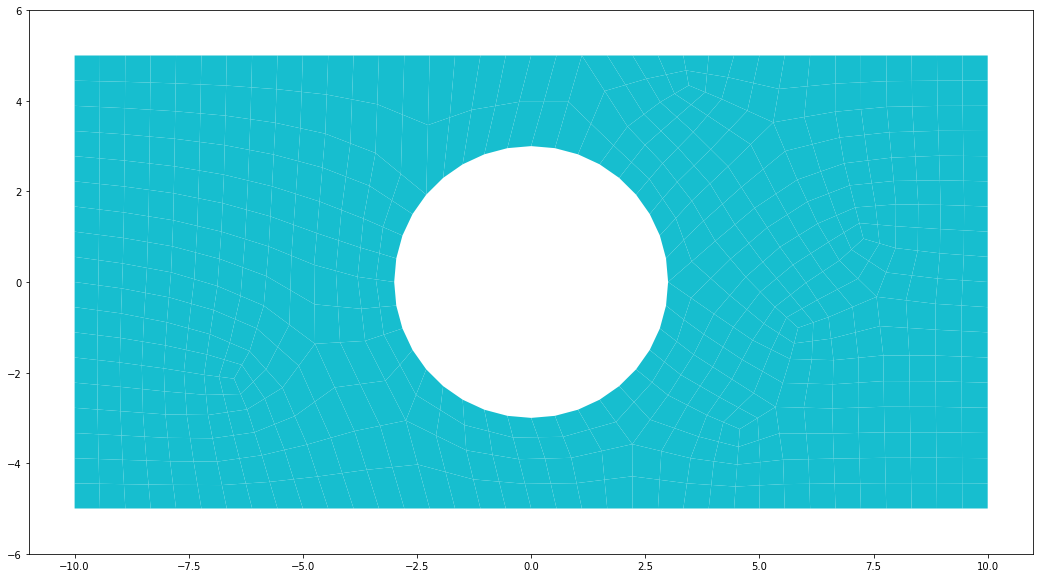

CPU times: user 1.05 s, sys: 31.2 ms, total: 1.08 s
Wall time: 1.13 s


In [5]:
%%time
x, y, figs_nodes, dict_of_nodes = read_nodes_file('meshes/mesh_v2_628nodes.k')
draw_mesh(figs_nodes, dict_of_nodes)
plt.show()
# plt.savefig('fig1')

In [6]:
def Geron(x1, y1, x2, y2, x3, y3):
    '''
    Функция для расчета площади треугольника.
    На вход принимает:
        координаты трех точек треугольника.
    Возвращает:
        S - площадь.
    '''
    A = np.array([[x1 - x3, y1 - y3],
                  [x2 - x3, y2 - y3]])
    S = abs(np.linalg.det(A))
    
    return S*1/2

def get_centre_os_sqr(x1, y1, x2, y2, x3, y3, x4, y4):
    '''
    Функция для расчета центра четырехугольника.
    На вход принимает:
        координаты четырех точек четырехугольника.
    Возвращает:
        x5, y5 - координаты центра.
    '''
    x5 = (x1 + x2 + x3 + x4)/4 
    y5 = (y1 + y2 + y3 + y4)/4
    
    return x5, y5

def get_area_of_sqr(x1, y1, x2, y2, x3, y3, x4, y4):
    '''
    Функция для расчета площади четырехугольника.
    На вход принимает:
        координаты четырех точек четырехугольника.
    Возвращает:
        S - площадь.
    '''    
    S1 = Geron(x1, y1, x2, y2, x4, y4)
    S2 = Geron(x1, y1, x2, y2, x3, y3)
    S3 = Geron(x4, y4, x2, y2, x3, y3)
    S4 = Geron(x1, y1, x4, y4, x3, y3)
    
    return np.array([S1, S2, S3, S4])

# Geron(x1=0, y1=0, x2=-1, y2=0, x3=0, y3=1)

def get_D():
    '''
    Функция создает матрицу D.
    На вход принимает:
    Возвращает:
        D - матрица.
    '''
    D = np.array([[1, mu , 0],
                  [mu, 1, 0],
                  [0, 0, (1-mu)/2]])
    
    return E * D / (1-mu**2)


def get_B(x1, y1, x2, y2, x3, y3, x4, y4):
    '''
    Функция создает матрицу B.
    На вход принимает:
        координаты четырех точек четырехугольника.
    Возвращает:
        B - матрица.
    '''
    B = np.array([[y2 - y4, y3 - y1],
                  [x4 - x2, x1 - x3]])
    s_i = get_area_of_sqr(x1, y1, x2, y2, x3, y3, x4, y4)
    
    return B / (2 * sum(s_i) * 0.5)

# get_B(x1=0, y1=0, x2=-1, y2=0, x3=0, y3=1)

In [13]:
def get_dN(figs_nodes, dict_of_nodes):
    '''
    '''
    N = np.shape(figs_nodes)[0]
    M = len(dict_of_nodes)
    
    brackets = lambda k, e: np.array([[0      ,  (1 - e),  (e - k),  (k - 1)],
                                      [(e - 1),       0 ,  (1 + k), -(e + k)],
                                      [(k - e), -(1 + k),       0 ,  (1 + e)],
                                      [(1 - k),  (k + e), -(1 + e),      0 ]]) / 8
    
    coord = [[-1, -1], [1, -1], [1, 1], [-1, 1]]
    brackets_matrix_all = [brackets(k, e) for (k, e) in coord]
    
    XX = np.zeros((M, M))
    YY = np.zeros((M, M))
    XY = np.zeros((M, M))
   
    for fig_id in range(N):
        curr_fig=figs_nodes[fig_id]

        coords=np.array([dict_of_nodes[curr_fig[0]],
                         dict_of_nodes[curr_fig[1]],
                         dict_of_nodes[curr_fig[2]],
                         dict_of_nodes[curr_fig[3]]])

        X, Y = coords.T
        XX_local = np.zeros((4, 4))
        YY_local = np.zeros((4, 4))
        XY_local = np.zeros((4, 4))

        for brackets_matrix in brackets_matrix_all:
            dN_dX_local = brackets_matrix @ Y
            dN_dY_local = X @ brackets_matrix
            J = np.abs(X @ dN_dX_local)
            XX_local += dN_dX_local[:, np.newaxis] @ dN_dX_local[np.newaxis, :] / J
            YY_local += dN_dY_local[:, np.newaxis] @ dN_dY_local[np.newaxis, :] / J
            XY_local += dN_dX_local[:, np.newaxis] @ dN_dY_local[np.newaxis, :] / J
        
        for i in range(4):
            XX[curr_fig[i], curr_fig] += XX_local[i]
            YY[curr_fig[i], curr_fig] += YY_local[i]
            XY[curr_fig[i], curr_fig] += XY_local[i]
    
    return XX, YY, XY

def get_K_global(figs_nodes, dict_of_nodes):
    '''
    '''
    M = len(dict_of_nodes)
    K_global = np.zeros((2*M, 2*M))
    
    D = get_D()
    XX, YY, XY = get_dN(figs_nodes, dict_of_nodes)
    
    K_global[0::2, 0::2] = XX * D[0, 0] + YY * D[2, 2]
    K_global[1::2, 1::2] = YY * D[1, 1] + XX * D[2, 2]
    K_global[0::2, 1::2] = XY * D[0, 1] + XY.T * D[2, 2]
    K_global[1::2, 0::2] = XY.T * D[0, 1] + XY * D[2, 2]
    
    return K_global

def get_F_global(figs_nodes, dict_of_nodes, F=20):
    '''
    '''
    F_global = np.zeros((2*len(dict_of_nodes)))
    
    for tr in figs_nodes:
        x1, y1 = dict_of_nodes[tr[0]]
        x2, y2 = dict_of_nodes[tr[1]]
        x3, y3 = dict_of_nodes[tr[2]]
        x4, y4 = dict_of_nodes[tr[3]]
        
        original_id = {0:tr[0], 1:tr[1], 2:tr[2], 3:tr[3]}
        
        x = [x1, x2, x3, x4]
        y = [y1, y2, y3, y4]
        
        for i, j in zip([0, 1, 2, 3], [3, 0, 1, 2]):
            if (abs(x[i]) == l) & (abs(x[j]) == l):
                delta = np.array([y[i]-y[j], x[j]-x[i]]).T
                F_global[2 * original_id[j]:2 * original_id[j] + 2] += F * delta / (4 * h * t)
                F_global[2 * original_id[i]:2 * original_id[i] + 2] += F * delta / (4 * h * t)
                
    return F_global

# def get_F_global(figs_nodes, dict_of_nodes, F=20):
#     '''
#     '''
#     F_global = np.zeros((2*len(dict_of_nodes)))
    
#     for tr in figs_nodes:
#         x1, y1 = dict_of_nodes[tr[0]]
#         x2, y2 = dict_of_nodes[tr[1]]
#         x3, y3 = dict_of_nodes[tr[2]]
#         x4, y4 = dict_of_nodes[tr[3]]
        
#         original_id = {0:tr[0], 1:tr[1], 2:tr[2], 3:tr[3]}
        
#         x = [x1, x2, x3, x4]
#         y = [y1, y2, y3, y4]
        
#         for i, j in zip([0, 1, 2, 3], [3, 0, 1, 2]):
#             if ((np.sqrt(x[i]**2 + y[i]**2) > r - 0.0001 & np.sqrt(x[i]**2 + y[i]**2) < r + 0.0001) &
#                 (np.sqrt(x[j]**2 + y[j]**2) > r - 0.0001 & np.sqrt(x[j]**2 + y[j]**2) < r + 0.0001)):
#                 delta = np.array([y[i]-y[j], x[j]-x[i]]).T
#                 F_global[2 * original_id[j]:2 * original_id[j] + 2] += F * delta / (4 * h * t)
#                 F_global[2 * original_id[i]:2 * original_id[i] + 2] += F * delta / (4 * h * t)
                
#     return F_global
    
# def main_solver_2(K_global, F_global, figs_nodes, dict_of_nodes):
#     '''
#     Вектор узловых перемещений находится как решение СЛАУ.
#     На вход принимает:
#     Возвращает:
#         U - вектор узлового перемещения.
#     '''
#     U = []
#     U_row = np.linalg.solve(K_global, F_global)
    
#     for tr in figs_nodes:
#         x1, y1 = dict_of_nodes[tr[0]]
#         x2, y2 = dict_of_nodes[tr[1]]
#         x3, y3 = dict_of_nodes[tr[2]]
#         x4, y4 = dict_of_nodes[tr[3]]
    
#         tmp = np.zeros((2, 4))
#         tmp[0][0] = U_row[2 * tr[0]]
#         tmp[0][1] = U_row[2 * tr[1]]
#         tmp[0][2] = U_row[2 * tr[2]]
#         tmp[0][3] = U_row[2 * tr[3]]
#         tmp[1][0] = U_row[2 * tr[0] + 1]
#         tmp[1][1] = U_row[2 * tr[1] + 1]
#         tmp[1][2] = U_row[2 * tr[2] + 1]
#         tmp[1][3] = U_row[2 * tr[3] + 1]
        
#         U += [tmp.T]
    
#     return U

def reshape_U(figs_nodes, dict_of_nodes, U_row):
    '''
    '''
    U = []
    
    for tr in figs_nodes:
        x1, y1 = dict_of_nodes[tr[0]]
        x2, y2 = dict_of_nodes[tr[1]]
        x3, y3 = dict_of_nodes[tr[2]]
        x4, y4 = dict_of_nodes[tr[3]]
    
        tmp = np.zeros((2, 4))
        tmp[0][0] = U_row[2 * tr[0]]
        tmp[0][1] = U_row[2 * tr[1]]
        tmp[0][2] = U_row[2 * tr[2]]
        tmp[0][3] = U_row[2 * tr[3]]
        tmp[1][0] = U_row[2 * tr[0] + 1]
        tmp[1][1] = U_row[2 * tr[1] + 1]
        tmp[1][2] = U_row[2 * tr[2] + 1]
        tmp[1][3] = U_row[2 * tr[3] + 1]
        
        U += [tmp.T]
    
    return U


def get_M_global(figs_nodes, dict_of_nodes, ro, t=1):
    '''
    '''
    N = len(dict_of_nodes)
    M_local = np.zeros((N, N))
    M_global = np.zeros((2*N, 2*N))
    simple = np.array([[4, 2, 1, 2], 
                       [2, 4, 2, 1],
                       [1, 2, 4, 2],
                       [2, 1, 2, 4]])/12
    
    for num, tr in enumerate(figs_nodes):
        x1, y1 = dict_of_nodes[tr[0]]
        x2, y2 = dict_of_nodes[tr[1]]
        x3, y3 = dict_of_nodes[tr[2]]
        x4, y4 = dict_of_nodes[tr[3]]
        
        s_i = get_area_of_sqr(x1, y1, x2, y2, x3, y3, x4, y4)
        S = sum(s_i) * 0.5
        S_local = simple*(S + s_i[:, np.newaxis] + s_i[np.newaxis, :])
        
        M_local[tr, tr[0]] += S_local[0]
        M_local[tr, tr[1]] += S_local[1]
        M_local[tr, tr[2]] += S_local[2]
        M_local[tr, tr[3]] += S_local[3]
        
    M_global[0::2, 0::2] = M_local * ro * t / 6   
    M_global[1::2, 1::2] = M_local * ro * t / 6
    
    return M_global

In [8]:
def get_stress(U, deformation, figs_nodes, dict_of_nodes):
    '''
    Функция строит вектор напряжений.
    На вход принимает:
        U - вектор узловых перемещений;
        deformation - вектор деформаций;
        figs_nodes - последовательность индексов узлов, которые образуют фигуру;
        dict_of_nodes - словарь, ключом является индекс узла, а значвением является координаты этого узла;
    Возвращает:
        stress - вектор напряжений.
    '''
    stress = [0]*(len(figs_nodes))
    
    for num, tr in enumerate(figs_nodes):
        D = get_D()
        stress[num] = D @ deformation[num]
    
    return np.array(stress)


def get_deformation(U, figs_nodes, dict_of_nodes):
    '''
    Функция строит вектор деформаций.
    На вход принимает:
        U - вектор узловых перемещений;
        figs_nodes - последовательность индексов узлов, которые образуют фигуру;
        dict_of_nodes - словарь, ключом является индекс узла, а значвением является координаты этого узла.
    Возвращает:
        deformation - вектор деформаций.
    '''
    deformation = [0]*(len(figs_nodes))
    
    for num, tr in enumerate(figs_nodes):
        x1, y1 = dict_of_nodes[tr[0]]
        x2, y2 = dict_of_nodes[tr[1]]
        x3, y3 = dict_of_nodes[tr[2]]
        x4, y4 = dict_of_nodes[tr[3]]
        B = get_B(x1, y1, x2, y2, x3, y3, x4, y4)
        
        tmp = B @ (U[num][0:2] - U[num][2:4])
        deformation[num] = [tmp[0][0], tmp[1][1], tmp[1][0] + tmp[0][1]]
        
    return deformation

In [9]:
def get_R_func(F, A, step_i, t_j):
    '''
    '''
    t = (np.pi * (step_i * t_j - 1))**2
    func = F * A * (1 - 2 * t) * (np.e**(-t)) 
    return func

def main_solver_1(dict_of_nodes, M_global, K_global, F_global, steps=1000, t=0.002):
    '''
    '''
    N = len(dict_of_nodes)
    U = np.zeros((2*N, steps)) 
    V = np.zeros((2*N, steps))  
    alpha = np.zeros((2*N, steps))  
    
    for i in range(steps-1):
        f = get_R_func(F_global, 1, i, t)
        U[:,i + 1] = U[:,i] + V[:,i] * t + alpha[:,i] * t**2 / 2.
        b = f - K_global @ U[:,i+1]
        alpha[:, i+1] = np.linalg.solve(M_global, b)
        V[:, i+1] = V[:, i] + t * (alpha[:, i] + alpha[:, i+1]) / 2.

    return U, V

In [10]:
def use_CP(value, figs_nodes, dict_of_nodes):
    '''
    Метод согласованных результантов.
    Принимает на вход:
        value - list со значениями величины (например, напряжения);
        figs_nodes - последовательность индексов узлов, которые образуют фигуру;
        dict_of_nodes - словарь, ключом является индекс узла, а значвением является координаты этого узла.
    Возвращает:
        result - вектор со значениями результантов элементов
    '''
    N = len(dict_of_nodes)
    R = np.zeros(N)    
    M_local = np.zeros((N, N))
    simple = np.array([[4, 2, 1, 2], 
                       [2, 4, 2, 1],
                       [1, 2, 4, 2],
                       [2, 1, 2, 4]])/12
    
    for num, tr in enumerate(figs_nodes):
        x1, y1 = dict_of_nodes[tr[0]]
        x2, y2 = dict_of_nodes[tr[1]]
        x3, y3 = dict_of_nodes[tr[2]]
        x4, y4 = dict_of_nodes[tr[3]]

        s_i = get_area_of_sqr(x1, y1, x2, y2, x3, y3, x4, y4)
        S = sum(s_i) * 0.5
        S_local = simple*(S + s_i[:, np.newaxis] + s_i[np.newaxis, :])
        
        M_local[tr, tr[0]] += S_local[0]
        M_local[tr, tr[1]] += S_local[1]
        M_local[tr, tr[2]] += S_local[2]
        M_local[tr, tr[3]] += S_local[3]
        
        R[tr[0]] += (S + s_i[0])*value[num]
        R[tr[1]] += (S + s_i[1])*value[num]
        R[tr[2]] += (S + s_i[2])*value[num]
        R[tr[3]] += (S + s_i[3])*value[num]
    
    result = np.linalg.solve(M_local, R)
    
    return result

In [11]:
def check_tr(x1, y1, x2, y2, x3, y3, x0, y0):
    '''
    Функция проверяет, лежит ли точка в треугольнике.
    На вход получает:
        координаты трех точек треугольника;
        коориднаты точки, которую проверяем.
    Возвращает:
        res - ответ типа bool.
    '''
    Q = lambda x1, y1, x2, y2, x0, y0 : x0*(y2-y1) + y0*(x1-x2) + y1*x2 - x1*y2
    
    q1 = Q(x1, y1, x2, y2, x0, y0)
    q2 = Q(x2, y2, x3, y3, x0, y0)
    q3 = Q(x3, y3, x1, y1, x0, y0)
    
    res = (((q1 > 0) and (q2 > 0) and (q3 > 0)) or 
              ((q1 <= 0) and (q2 <= 0) and (q3 <= 0)))
    
    return res

def check_sqr(x1, y1, x2, y2, x3, y3, x4, y4, x0, y0):
    '''
    '''
    ch1 = (check_tr(x1, y1, x2, y2, x4, y4, x0, y0) == True)
    ch2 = (check_tr(x1, y1, x2, y2, x3, y3, x0, y0) == True)
    ch3 = (check_tr(x4, y4, x2, y2, x3, y3, x0, y0) == True)
    ch4 = (check_tr(x1, y1, x4, y4, x3, y3, x0, y0) == True)
    
    if sum([ch1, ch2, ch3, ch4]) > 0:
        return True
    else:
        return False
    

def find_tr_num(line, figs_nodes, dict_of_nodes):
    '''
    Функция ищет номера треугольников, которые содержат линию.
    На вход получает:
        line - линия;
        figs_nodes - последовательность индексов узлов, которые образуют фигуру;
        dict_of_nodes - словарь, ключом является индекс узла, а значвением является координаты этого узла.
    Возвращает:
        line_of_num - словарь, ключом является индекс треугольника, а значением явзяется координаты лежащей в нем точки.
    '''
    line_of_num = {}
    
    for x in line:
        x0, y0 = x[0], x[1]
        for num, tr in enumerate(figs_nodes):
            x1, y1 = dict_of_nodes[tr[0]]
            x2, y2 = dict_of_nodes[tr[1]]
            x3, y3 = dict_of_nodes[tr[2]]
            x4, y4 = dict_of_nodes[tr[3]]
            
            
            if check_sqr(x1, y1, x2, y2, x3, y3, x4, y4, x0, y0) == True:
                line_of_num[num] = x
                
    return line_of_num

# Let's run code

In [14]:
# Запуск программы
global E, mu, F, l, h, r, t, ro

E = 200
mu = 0.1

F = 20 # Воздействие на боковые стороны
l = 10   # Расстояние от центра отверстия до одной из боковых сторон
h = 5   # Расстояние от центра отверстия до верхней и нижней сторон
r = 3  # Радиус отверстия
t = 1
ro = 0.9

K_global = get_K_global(figs_nodes, dict_of_nodes)
F_global = get_F_global(figs_nodes, dict_of_nodes)
M_global = get_M_global(figs_nodes, dict_of_nodes, ro)

U, V = main_solver_1(dict_of_nodes, M_global, K_global, F_global)

u_i = reshape_U(figs_nodes, dict_of_nodes, U[:, int(0.8/0.002)-1])
deformation = get_deformation(u_i, figs_nodes, dict_of_nodes)
stress = get_stress(u_i, deformation, figs_nodes, dict_of_nodes)

# U_ = main_solver_2(K_global, F_global.T, figs_nodes, dict_of_nodes)
# deformation = get_deformation(U, figs_nodes, dict_of_nodes)
# stress = get_stress(U, deformation, figs_nodes, dict_of_nodes)


Напряжение по оси X со смещением


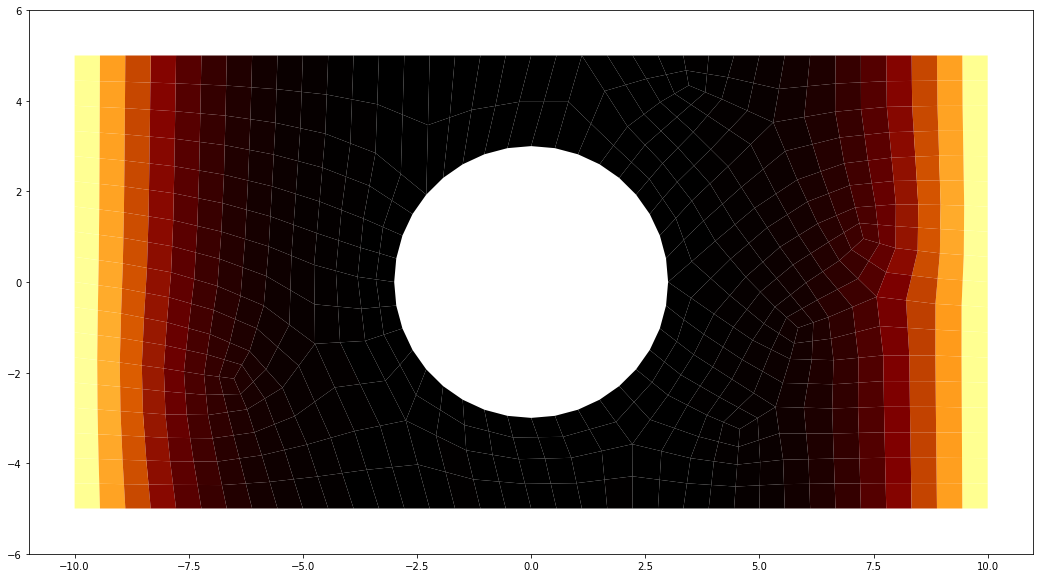

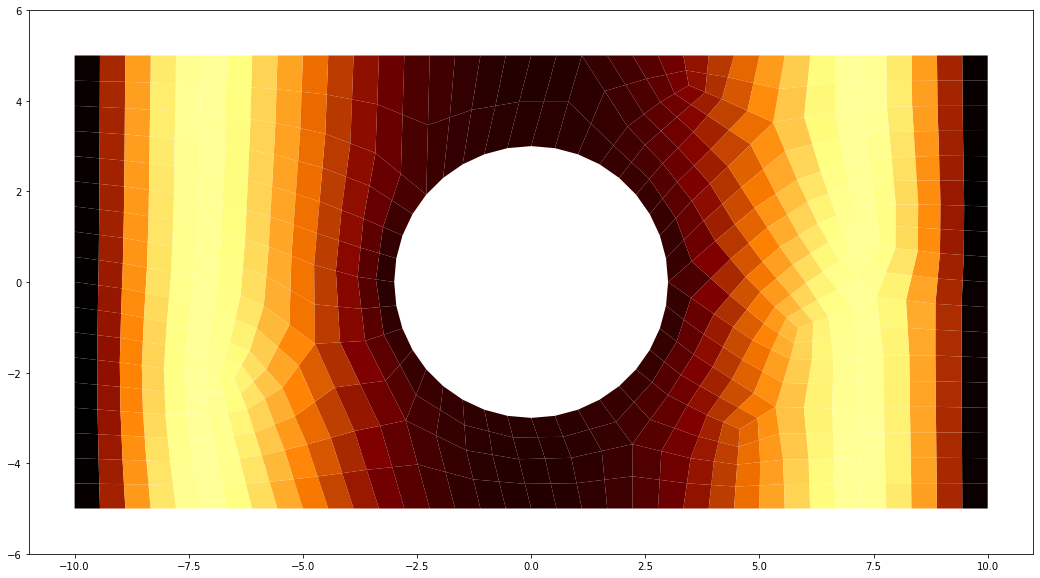

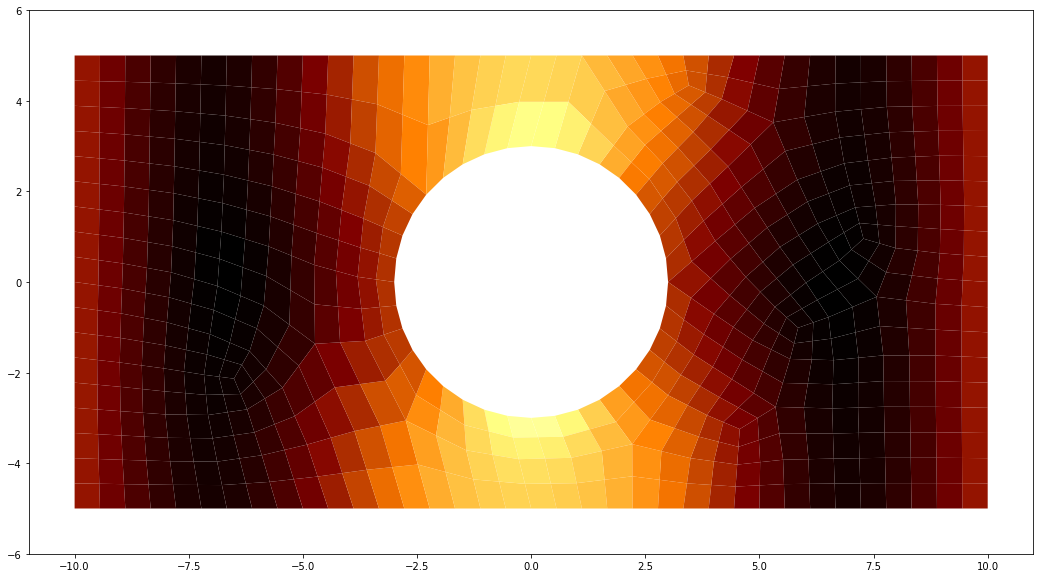

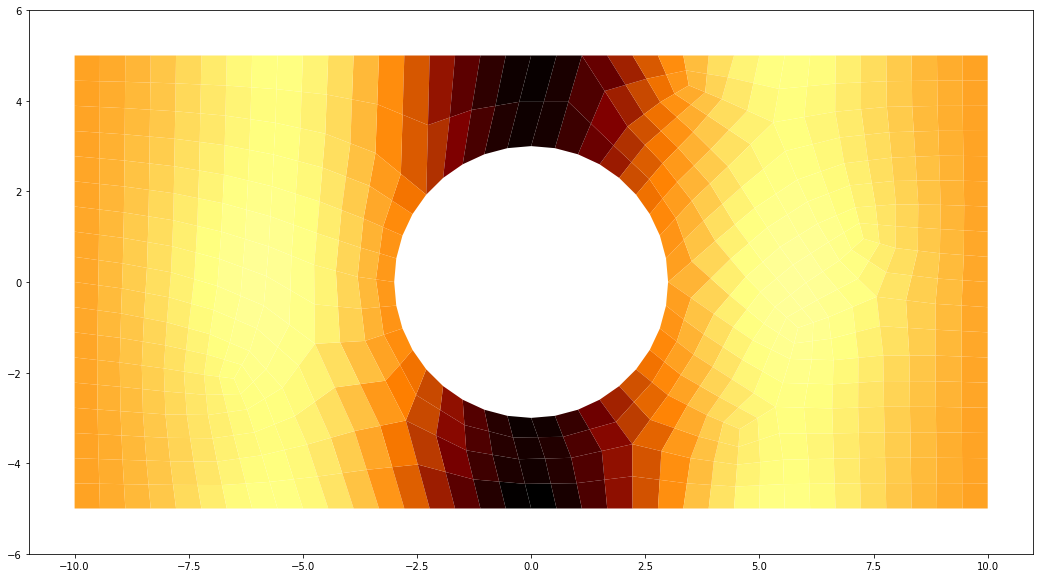

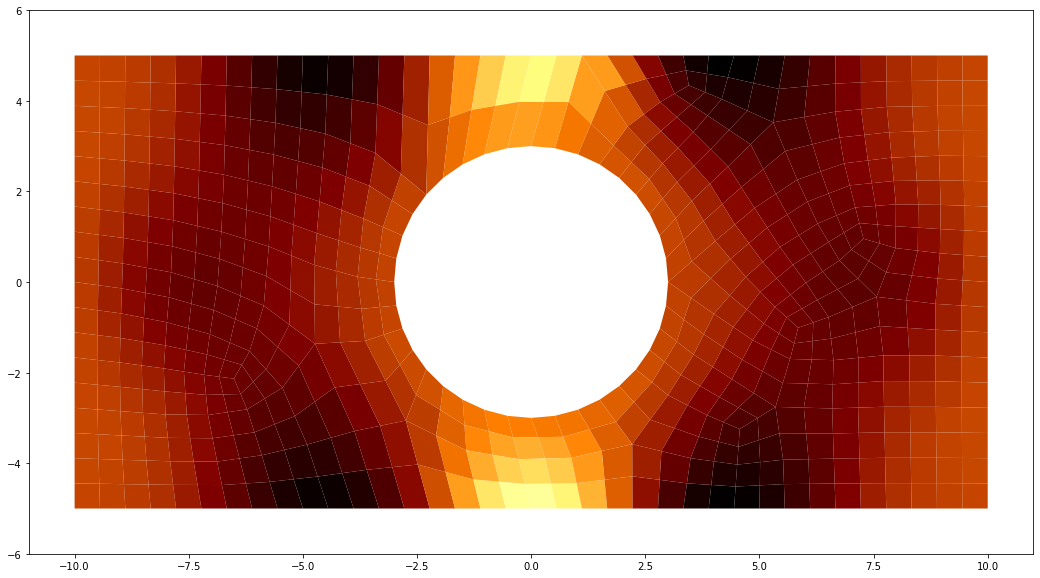

In [15]:
new_dict_of_nodes = {}
    
print('Напряжение по оси X со смещением')
for i in [199, 399, 599, 799, 999]:
    u_i = reshape_U(figs_nodes, dict_of_nodes, U[:, i])
    deformation = get_deformation(u_i, figs_nodes, dict_of_nodes)
    stress = get_stress(u_i, deformation, figs_nodes, dict_of_nodes)
    
    draw_mesh(figs_nodes,
              dict_of_nodes,
              stress[:,0])
    plt.savefig('fig'+str(i))

In [16]:
# x_line = np.linspace([-r+0.00002, 0], [-l-0.00002, 0], 100)
# tr_num = find_tr_num(x_line, figs_nodes, dict_of_nodes)
# stress_CP = use_CP(stress[:,0], figs_nodes, dict_of_nodes)

# plt.figure(figsize=(15, 10))
# plt.title('Напряжение по оси X', fontsize=15)
# plt.plot(np.array(list(tr_num.values()))[:, 0], 
#          stress[list(tr_num.keys()), 0])
# plt.plot(np.array(list(tr_num.values()))[:, 0], 
#          [sum(stress_CP[i])/4 for i in np.array(figs_nodes)[list(tr_num.keys())]])
# plt.legend(['негладкое решение', 'решение методом СР'])
# # plt.savefig('fig4')
# plt.show()

# Сеточная сходимость

finished for  316
finished for  628
finished for  1410
finished for  2464


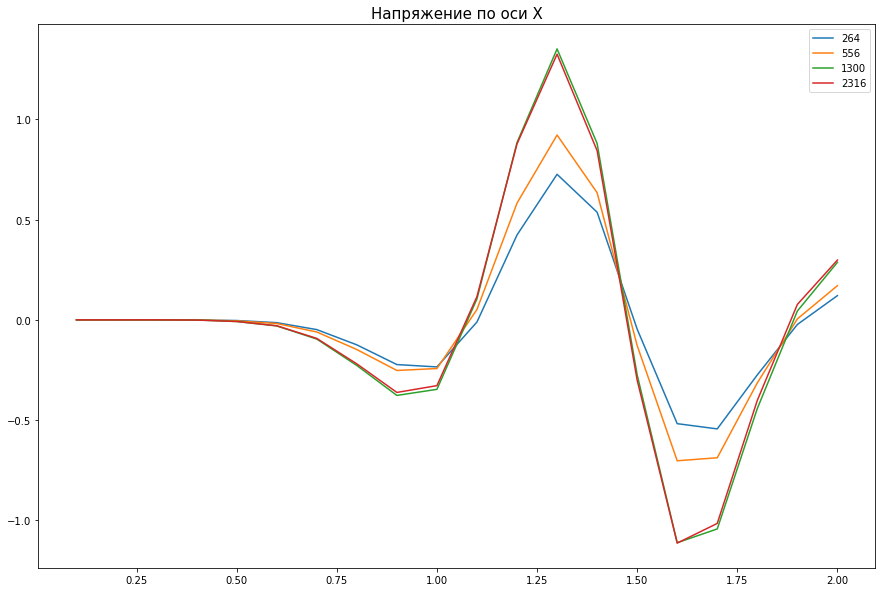

In [18]:
plt.figure(figsize=(15, 10))
plt.title('Напряжение по оси X', fontsize=15)

i = 0
files_list = sorted([filename for filename in glob.glob(r'meshes/*.k')],
                    reverse=False)

for filename in files_list:
    x, y, figs_nodes, dict_of_nodes = read_nodes_file(filename)
    
    K_global = get_K_global(figs_nodes, dict_of_nodes)
    F_global = get_F_global(figs_nodes, dict_of_nodes)
    M_global = get_M_global(figs_nodes, dict_of_nodes, ro)

    U, V = main_solver_1(dict_of_nodes, M_global, K_global, F_global)
    
    motion_steps = np.arange(0.1,2.1,0.1)
    u_t = {t: U[:, int(t / 0.002) - 1] for t in motion_steps}
    u_in_motion = {t: reshape_U(figs_nodes, dict_of_nodes, u_t[t]) for t in motion_steps}
    deformation_in_motion = {t:get_deformation(u_in_motion[t], figs_nodes, dict_of_nodes) for t in motion_steps}
    stress_in_motion = {t:get_stress(u_in_motion[t], deformation_in_motion[t], figs_nodes, dict_of_nodes) for t in motion_steps}
    
    x_line = np.linspace([-r+0.00002, 0], [-l-0.00002, 0], 10)[1]
    tr_num = find_tr_num([x_line], figs_nodes, dict_of_nodes)
    stress_CP_in_motion = {t:use_CP(stress_in_motion[t][:,0], figs_nodes, dict_of_nodes) for t in motion_steps}
    stress = 0
    
    plt.plot(motion_steps, [sum(stress_CP_in_motion[t][figs_nodes[list(tr_num.keys())[0]]])/4 for t in motion_steps], label = len(figs_nodes))
    plt.legend()
    print('finished for ', len(dict_of_nodes))
# plt.savefig('fig2')